# Enumerating an MGRS Tile

The previous notebook went into detail about specifying the inputs for a single DIST-S1 product. Now, we want to create a time-series of DIST-S1 products, and specifying these inputs.

To do this, we will still select an Area of Interest (AOI). This time, we will not need to specify the track number nor the post-image date. We will simply get *all* the products that can be obtained from a given MGRS tile. Additional temporal ranges on the post-image dates or track numbers can be used to filter the number of products, but that is not the focus of this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from pathlib import Path

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.crs import CRS
from shapely.geometry import Point

from dist_s1_enumerator import (
    get_burst_table_from_mgrs_tiles,
    get_lut_by_mgrs_tile_ids,
    get_mgrs_burst_lut_path,
    get_mgrs_tiles_overlapping_geometry,
)
from dist_s1_enumerator.asf import get_rtc_s1_ts_metadata_from_mgrs_tiles
from dist_s1_enumerator.dist_enum import enumerate_dist_s1_products

# Provide AOI

In [3]:
# Wax Lake Delta
point = Point(-91.45, 29.5)
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))

# Visualize MGRS Tiles overlapping the AOI

This is a rehash of the previous notebook as it is still relevant./

In [4]:
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,15RXN,32615,"MULTIPOLYGON(((600000 3300000,600000 3190200,7...","POLYGON ((-91.96499 29.82641, -91.97495 28.835..."


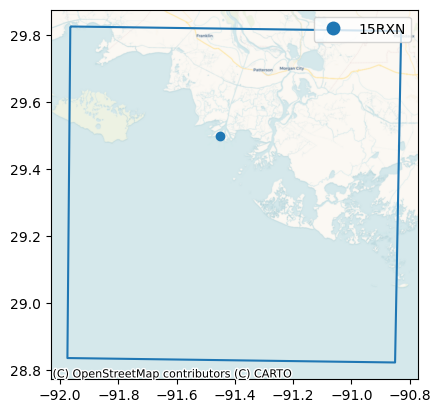

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, legend=True, ax=ax
)
df_aoi.plot(ax=ax)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

# Visualize Bursts over the MGRS Tiles

In [6]:
MGRS_TILE_IDS = ["15RXN"]

In [7]:
df_bursts = get_burst_table_from_mgrs_tiles(MGRS_TILE_IDS)
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T063-133337-IW3,63,0,15RXN,"POLYGON ((-91.1627 28.57844, -90.35433 28.6981..."
1,T063-133338-IW2,63,0,15RXN,"POLYGON ((-92.07298 28.55011, -91.15958 28.692..."
2,T063-133338-IW3,63,0,15RXN,"POLYGON ((-91.19651 28.74463, -90.38697 28.864..."
3,T063-133339-IW2,63,0,15RXN,"POLYGON ((-92.10828 28.71639, -91.19336 28.858..."
4,T063-133339-IW3,63,0,15RXN,"POLYGON ((-91.23035 28.91082, -90.41946 29.030..."


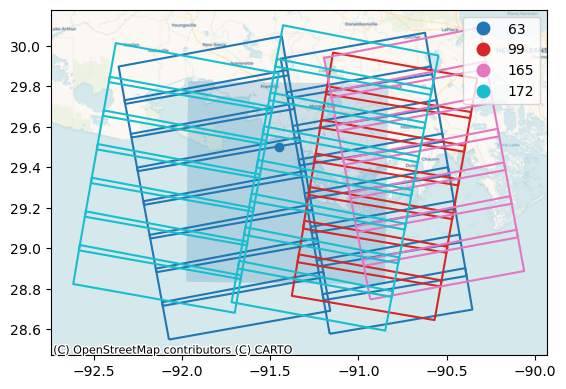

In [8]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2
)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

# Get the RTC Metadata for the Time-Series over the MGRS Tiles

Rather than selecting a track, we can enumerate across all tracks. Note that I commented out the track numbers, which would be used to group a pass.

In [9]:
df_ts = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    MGRS_TILE_IDS,
    # track_numbers=[63]
)
df_ts.head(5)

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T063-133337-IW3_20220101T00102...,T063-133337-IW3,2022-01-01 00:10:21+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16935 28.57693, -90.33732 28.705...",15RXN,0,63
1,OPERA_L2_RTC-S1_T063-133338-IW2_20220101T00102...,T063-133338-IW2,2022-01-01 00:10:23+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.0802 28.54292, -91.13725 28.6940...",15RXN,0,63
2,OPERA_L2_RTC-S1_T063-133338-IW3_20220101T00102...,T063-133338-IW3,2022-01-01 00:10:24+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.2032 28.74326, -90.3698 28.87127...",15RXN,0,63
3,OPERA_L2_RTC-S1_T063-133339-IW2_20220101T00102...,T063-133339-IW2,2022-01-01 00:10:25+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.11549 28.7091, -91.17097 28.8601...",15RXN,0,63
4,OPERA_L2_RTC-S1_T063-133339-IW3_20220101T00102...,T063-133339-IW3,2022-01-01 00:10:26+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.23717 28.91009, -90.40238 29.037...",15RXN,0,63


# Enumerate DIST-S1 Products

In [10]:
df_products = enumerate_dist_s1_products(df_ts, MGRS_TILE_IDS)
df_products.head()

Enumerating by MGRS tiles: 100%|█| 1/1 [00:00<00:00, 


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
0,OPERA_L2_RTC-S1_T063-133337-IW3_20240818T00102...,T063-133337-IW3,2024-08-18 00:10:29+00:00,2024-08-18,VV+VH,63,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16987 28.57637, -90.32567 28.706...",15RXN,0,63,pre,0
1,OPERA_L2_RTC-S1_T063-133338-IW2_20240818T00103...,T063-133338-IW2,2024-08-18 00:10:31+00:00,2024-08-18,VV+VH,63,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08065 28.54226, -91.12289 28.695...",15RXN,0,63,pre,0
2,OPERA_L2_RTC-S1_T063-133338-IW3_20240818T00103...,T063-133338-IW3,2024-08-18 00:10:32+00:00,2024-08-18,VV+VH,63,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.20366 28.74246, -90.35806 28.872...",15RXN,0,63,pre,0
3,OPERA_L2_RTC-S1_T063-133339-IW2_20240818T00103...,T063-133339-IW2,2024-08-18 00:10:34+00:00,2024-08-18,VV+VH,63,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.11599 28.70869, -91.15664 28.862...",15RXN,0,63,pre,0
4,OPERA_L2_RTC-S1_T063-133339-IW3_20240818T00103...,T063-133339-IW3,2024-08-18 00:10:35+00:00,2024-08-18,VV+VH,63,647,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.23758 28.90904, -90.39057 29.038...",15RXN,0,63,pre,0


The total products enumerated are:

In [11]:
len(df_products.product_id.unique())

68

The tracks that were used are:

In [12]:
df_products.track_number.unique()

array([ 63, 165])

# Inspecting idividual product inputs

In [13]:
PRODUCT_ID = 10

PROD_IND = df_products.product_id == PRODUCT_ID
PRE_IND = df_products.input_category == "pre"
POST_IND = df_products.input_category == "post"

df_post_prod = df_products[PROD_IND & POST_IND]
df_pre_prod = df_products[PROD_IND & PRE_IND]

print(
    f"The number of RTC products for product id {PRODUCT_ID} are {df_products[PROD_IND].shape[0]} products"
)
print(
    f"The number of pre-image RTC products for product id {PRODUCT_ID} are {df_pre_prod.shape[0]} products"
)
print(
    f"The number of post-image RTC products for product id {PRODUCT_ID} are {df_post_prod.shape[0]} products"
)

The number of RTC products for product id 10 are 176 products
The number of pre-image RTC products for product id 10 are 160 products
The number of post-image RTC products for product id 10 are 16 products


In [14]:
df_products[PROD_IND].head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
1760,OPERA_L2_RTC-S1_T063-133337-IW3_20240420T00103...,T063-133337-IW3,2024-04-20 00:10:31+00:00,2024-04-20,VV+VH,63,627,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16957 28.57768, -90.32545 28.707...",15RXN,0,63,pre,10
1761,OPERA_L2_RTC-S1_T063-133338-IW2_20240420T00103...,T063-133338-IW2,2024-04-20 00:10:33+00:00,2024-04-20,VV+VH,63,627,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08021 28.54334, -91.12255 28.696...",15RXN,0,63,pre,10
1762,OPERA_L2_RTC-S1_T063-133338-IW3_20240420T00103...,T063-133338-IW3,2024-04-20 00:10:34+00:00,2024-04-20,VV+VH,63,627,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.20331 28.74353, -90.35781 28.873...",15RXN,0,63,pre,10
1763,OPERA_L2_RTC-S1_T063-133339-IW2_20240420T00103...,T063-133339-IW2,2024-04-20 00:10:36+00:00,2024-04-20,VV+VH,63,627,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.11552 28.70965, -91.15627 28.862...",15RXN,0,63,pre,10
1764,OPERA_L2_RTC-S1_T063-133339-IW3_20240420T00103...,T063-133339-IW3,2024-04-20 00:10:37+00:00,2024-04-20,VV+VH,63,627,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.23713 28.90961, -90.39022 29.039...",15RXN,0,63,pre,10


Let's also break out the pre-image set and post-image set. Note there are many more pre-images (to establish a baseline for measuring disturbance).

Text(0.5, 1.0, 'Post-images')

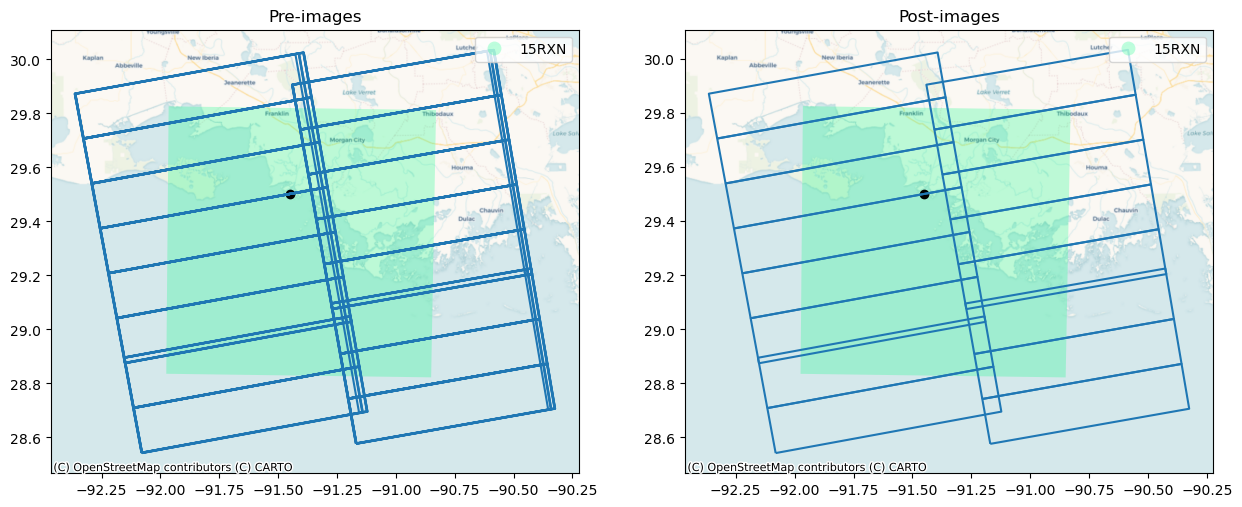

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for ax in axs:
    df_mgrs_tiles_plot.plot(
        column="mgrs_tile_id",
        categorical=True,
        legend=True,
        ax=ax,
        alpha=0.25,
        cmap="winter_r",
    )
    df_aoi.plot(ax=ax, color="black")


# pre-images
df_pre_prod.boundary.plot(ax=axs[0])
ctx.add_basemap(
    axs[0],
    crs=df_mgrs_tiles.crs.to_string(),
    source=ctx.providers.CartoDB.Voyager,
)
axs[0].set_title("Pre-images")


# Post-image
df_post_prod.boundary.plot(ax=axs[1])
ctx.add_basemap(
    axs[1],
    crs=df_mgrs_tiles.crs.to_string(),
    source=ctx.providers.CartoDB.Voyager,
)
axs[1].set_title("Post-images")